# DigitalExposome: Wellbeing Sınıflandırması
Bu çalışma, çevresel hava kalitesi ve insan fizyolojik verilerine dayanarak bireylerin "wellbeing" (iyi oluş) seviyelerini sınıflandırmayı hedefler. Modelleme süreci Python ve scikit-learn kütüphaneleri ile gerçekleştirilmiştir.


## 1. Verinin Yüklenmesi
CSV formatındaki veriseti yüklenir ve ilk satırlar incelenerek sütun yapısı ve veri örnekleri gözlemlenir.


In [53]:
# Kütüphaneler import edilir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Verisetini yükle
df = pd.read_csv("DigitalExposome Dataset.csv")
df.head()

,IBI,HR,NO2,Noise,NH3,PM10,CO,PM25,Label,PM1,EDA,BVP
0,0.0,0.377574,0.0,0.511358,0.003018,0.003091,0.871758,0.000000,5,0.000000,0.0,0.0
1,0.0,0.196398,0.0,0.490903,0.003018,0.003091,0.876848,0.003091,5,0.001854,0.0,0.0
2,0.0,0.454163,0.0,0.470449,0.006036,0.006181,0.881939,0.006181,5,0.003709,0.0,0.0
3,0.0,0.322451,0.0,0.449995,0.009055,0.009272,0.887030,0.009272,5,0.005563,0.0,0.0
4,0.0,0.237595,0.0,0.429540,0.012073,0.012362,0.892121,0.012362,5,0.007417,0.0,0.0


In [54]:
# Eksik değer kontrolü
print(df.isnull().sum())

IBI      0
HR       0
NO2      0
Noise    0
NH3      0
PM10     0
CO       0
PM25     0
Label    0
PM1      0
EDA      0
BVP      0
dtype: int64


## 2. Etiket Dağılımının Görselleştirilmesi
Verisetindeki 'Label' sütunundaki değerlerin frekansı hesaplanır ve görselleştirilerek sınıf dengesizliği olup olmadığı analiz edilir.


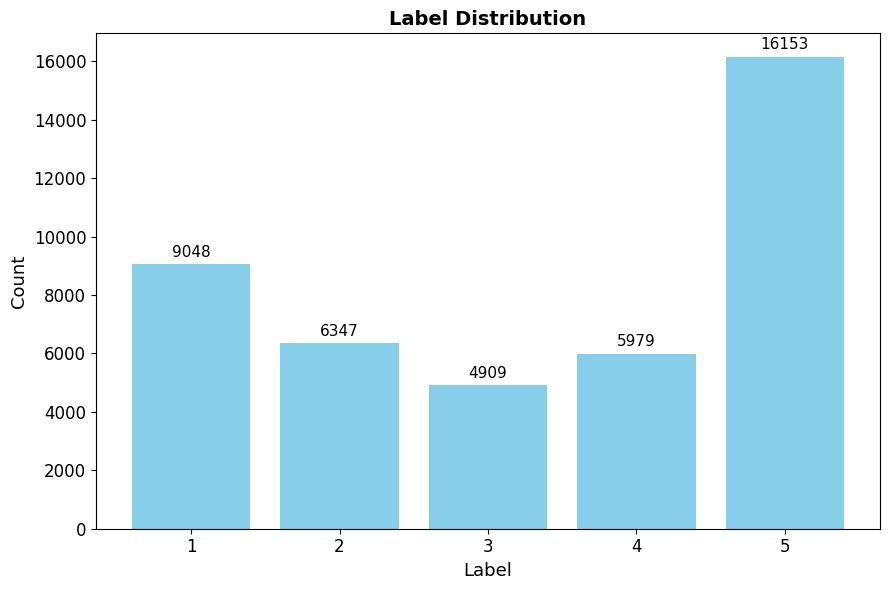

In [55]:
# Etiket dağılımını görselleştirmek için fonksiyon
def ShowLabelCounts():
    label_counts = df['Label'].value_counts()
    labels = label_counts.index
    counts = label_counts.values

    # Grafik boyutu ve çubuk grafiği oluştur
    plt.figure(figsize=(9, 6))
    bars = plt.bar(labels, counts, color='skyblue')

    # Başlık ve eksen etiketleri
    plt.title('Label Distribution', fontsize=14, weight='bold')
    plt.xlabel('Label', fontsize=13)
    plt.ylabel('Count', fontsize=13)

    # Çubukların üzerine sayıları yaz
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2,
                 height + (max(counts) * 0.01),
                 f'{int(height)}', ha='center', va='bottom', fontsize=11)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Fonksiyonu çağır
ShowLabelCounts()


## 3. Özelliklerin ve Etiketlerin Ayrılması
Tahmin edilecek etiket (y) ile özellikler (x) ayrılır. Daha sonra veri eğitim ve test setlerine bölünür.


In [56]:
# Verisetini y (tahmin edilecek label değeri) ve x (tahmin etmek için kullanılacak parametreler) olarak ayır.
y = df.iloc[:, 8:9]
x = df.drop(y, axis=1)

In [57]:
# Verisetini train ve test olarak ayır.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=17)

In [58]:
print("Train DataSet\n-----------------------------------------------------")
print(y_train['Label'].value_counts())
print("\n------------------------------------------------------\nTest DataSet\n------------------------------------------------------")
print(y_test['Label'].value_counts())

Train DataSet
-----------------------------------------------------
Label
5    9622
1    5470
2    3848
4    3606
3    2915
Name: count, dtype: int64

------------------------------------------------------
Test DataSet
------------------------------------------------------
Label
5    6531
1    3578
2    2499
4    2373
3    1994
Name: count, dtype: int64


## 4. Random Forest ile Model Eğitimi
Random Forest algoritması kullanılarak model oluşturulur ve eğitim verisi ile eğitilir.


In [59]:
# Random Forest Classifier Modeli uygula
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, criterion="entropy")
rfc.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='entropy', n_estimators=10)

In [60]:
# Test veriseti üzerinde tahmin yap
y_pred = rfc.predict(x_test)
rfc.score(x_test, y_test)

0.9737849779086892

## 5. Sınıflandırma Performansının Görselleştirilmesi
Precision, recall ve f1-score metrikleri her sınıf için hesaplanarak ısı haritası şeklinde görselleştirilir.


In [61]:
# Raporu al
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      3578
           2       0.97      0.96      0.96      2499
           3       0.96      0.96      0.96      1994
           4       0.96      0.95      0.96      2373
           5       0.98      0.99      0.99      6531

    accuracy                           0.97     16975
   macro avg       0.97      0.97      0.97     16975
weighted avg       0.97      0.97      0.97     16975



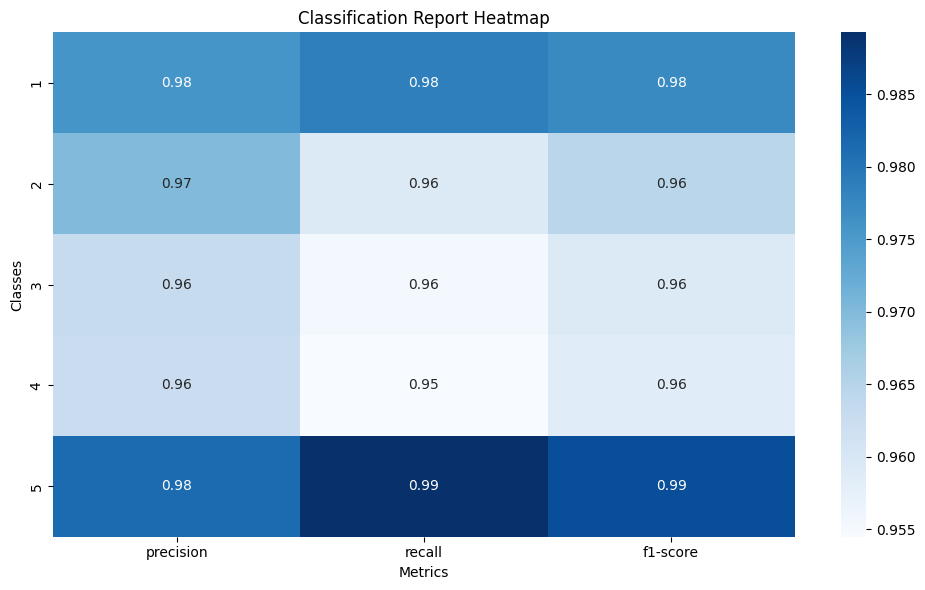

In [62]:
# Pandas DataFrame'e çevir
df_report = pd.DataFrame(report).transpose()

# Sadece sınıfları filtrele (accuracy, macro avg, vs. hariç)
df_filtered = df_report.iloc[:-3, :]

# Görselleştir
plt.figure(figsize=(10, 6))
sns.heatmap(df_filtered[['precision', 'recall', 'f1-score']], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.tight_layout()
plt.show()


## 6. Bireysel Tahmin İncelemesi
Test setinden bir örnek seçilerek modelin tahmin ettiği sınıf ile gerçek sınıf karşılaştırılır.


In [63]:
sample = x_test.iloc[1010]
sample_reshaped = sample.values.reshape(1, -1)
prediction = rfc.predict(sample_reshaped)

print("Tahmin edilen sınıf:", prediction[0])
print("Gerçek sınıf:", y_test.iloc[1010, 0])


Tahmin edilen sınıf: 2
Gerçek sınıf: 2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## 7. Confusion Matrix (Karışıklık Matrisi)
Modelin hangi sınıfları ne kadar doğru veya hatalı tahmin ettiğini gösterir. Görsel analiz için ısı haritası şeklinde sunulur.


In [64]:
# Confusion matrix hesapla
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[3502   26   10    2   38]
 [  50 2397   23   13   16]
 [  11   30 1905   34   14]
 [   5    8   40 2265   55]
 [  21   10    0   39 6461]]


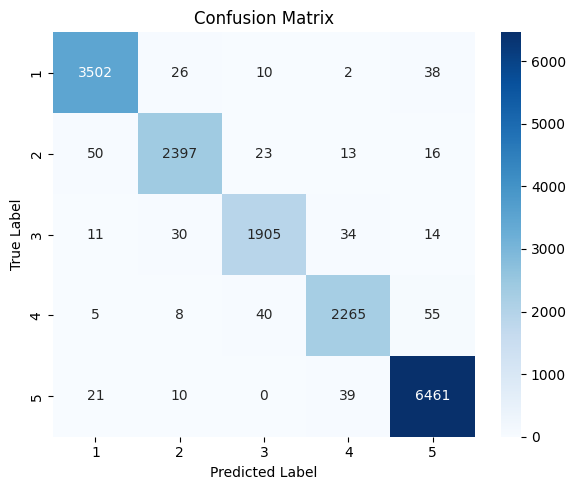

In [65]:
# Sınıf isimlerini belirle
class_names = ['1', '2','3','4','5']

# Görselleştir
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## 8. ROC Eğrileri ile Sınıf Bazlı AUC Analizi
Çoklu sınıflandırma problemi için ROC eğrileri her bir sınıf için çizilir. Her bir sınıfın AUC (Area Under Curve) değeri görsel olarak sunulur.


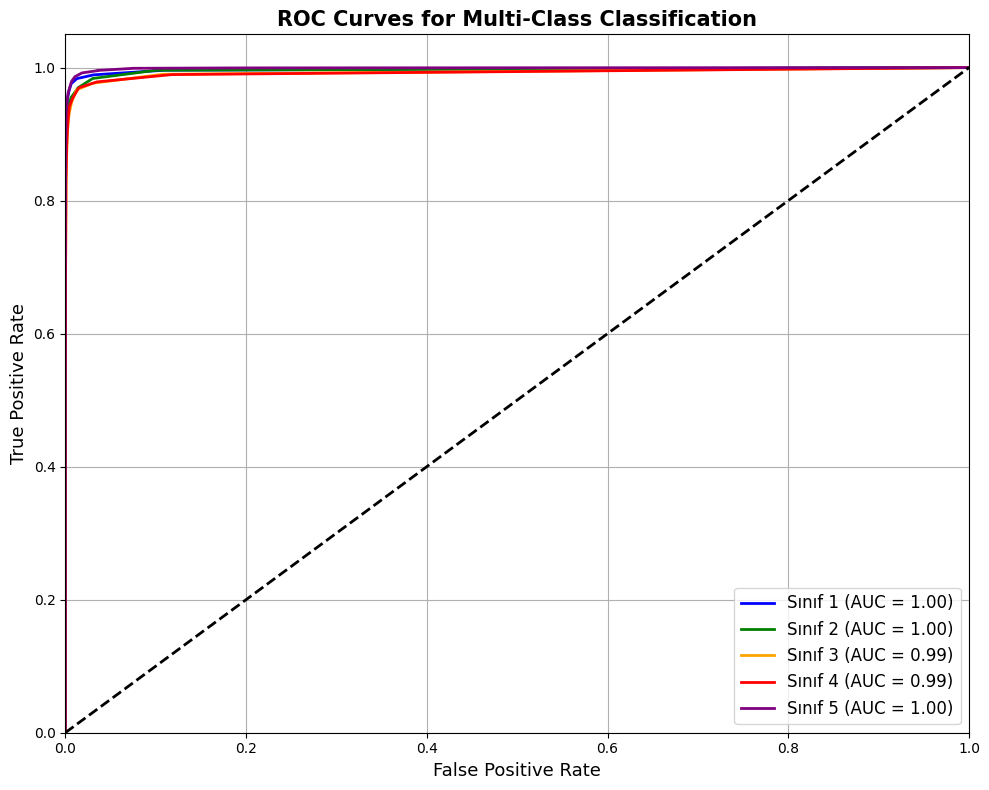

In [66]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import RocCurveDisplay

# Etiketleri binarize et (One-hot encoding)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
n_classes = y_test_bin.shape[1]

# Yeni model tanımlayıp eğit (pipeline ile birlikte - ROC için ihtiyaç duyulur)
model = make_pipeline(StandardScaler(), OneVsRestClassifier(RandomForestClassifier(n_estimators=10, criterion="entropy")))
model.fit(x_train, label_binarize(y_train, classes=[1, 2, 3, 4, 5]))

# Skorları al
y_score = model.predict_proba(x_test)

# ROC eğrileri için ayar
fpr = dict()
tpr = dict()
roc_auc = dict()

# Her sınıf için ROC eğrisi hesapla
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tüm sınıflar için ROC eğrilerini çiz
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Sınıf {i+1} (AUC = {roc_auc[i]:0.2f})')

# Referans (şans) eğrisi
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curves for Multi-Class Classification', fontsize=15, weight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## 9. Diğer Sınıflandırma Yöntemleri



### I. Logistic Regression



In [68]:
from sklearn.linear_model import LogisticRegression

# Modeli oluştur ve eğit
model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# Doğruluk ve diğer metrikler
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           1       0.48      0.58      0.52      3578
           2       0.56      0.38      0.45      2499
           3       0.34      0.09      0.14      1994
           4       0.41      0.06      0.10      2373
           5       0.49      0.76      0.59      6531

    accuracy                           0.49     16975
   macro avg       0.45      0.37      0.36     16975
weighted avg       0.47      0.49      0.44     16975



### II. Decision Tree



In [69]:
from sklearn.tree import DecisionTreeClassifier

# Modeli oluştur ve eğit
model = DecisionTreeClassifier(criterion="entropy", random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# Doğruluk ve diğer metrikler
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.96      0.96      3578
           2       0.95      0.95      0.95      2499
           3       0.94      0.94      0.94      1994
           4       0.94      0.93      0.94      2373
           5       0.97      0.98      0.97      6531

    accuracy                           0.96     16975
   macro avg       0.95      0.95      0.95     16975
weighted avg       0.96      0.96      0.96     16975



### III. Support Vector Machine




In [70]:
from sklearn.svm import SVC

# SVM modelini oluşturma ve eğitme
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(x_train, y_train)

y_pred = svm_model.predict(x_test)

# Doğruluk ve diğer metrikler
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           1       0.46      0.60      0.52      3578
           2       0.65      0.24      0.35      2499
           3       0.00      0.00      0.00      1994
           4       0.25      0.00      0.00      2373
           5       0.48      0.83      0.61      6531

    accuracy                           0.48     16975
   macro avg       0.37      0.33      0.30     16975
weighted avg       0.41      0.48      0.40     16975



### IV. Gaussian Naive Bayes

In [71]:
from sklearn.naive_bayes import GaussianNB

# Modeli oluştur ve eğit
gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_test)

# Doğruluk ve diğer metrikler
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.35      0.67      0.46      3578
           2       0.40      0.58      0.47      2499
           3       0.25      0.03      0.06      1994
           4       0.31      0.18      0.23      2373
           5       0.57      0.42      0.48      6531

    accuracy                           0.42     16975
   macro avg       0.38      0.38      0.34     16975
weighted avg       0.42      0.42      0.39     16975



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
